# Personalized product recommendation

# importing libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices
     

# Importing Dataset

In [91]:
df = pd.read_csv("C:\\Users\\tirum\\Downloads\\ratings_Electronics1.csv",header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

# shape

In [9]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)
     

No of rows =  1048576
No of columns =  3


# Datatypes

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1048576 non-null  object
 1   prod_id  1048576 non-null  object
 2   rating   1048576 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.0+ MB


# missing values

In [11]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

# summary

In [12]:
# Summary statistics of 'rating' variable
df['rating'].describe()
     

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

# Rating distribution

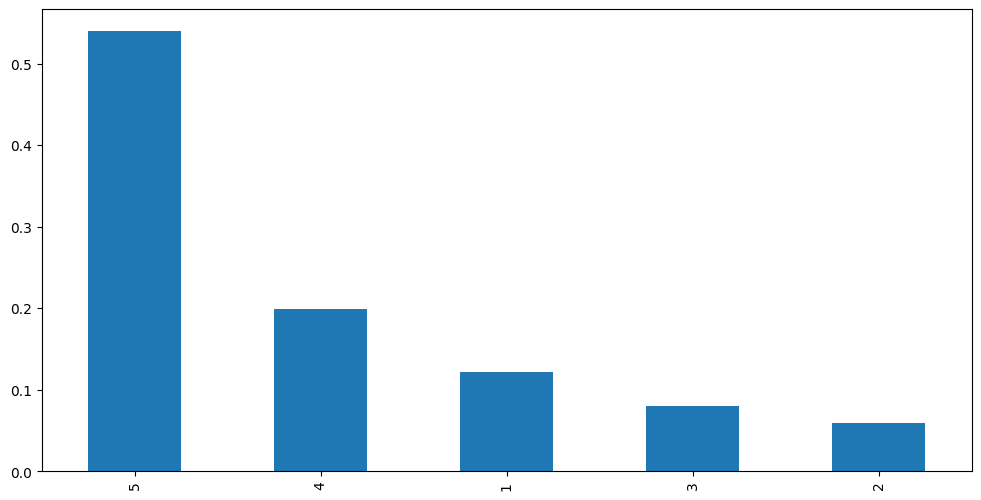

In [13]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

In [ ]:
The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

# No of unique users and items

In [14]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  786330
Number of unique ITEMS in Raw data =  61894


# Users with most no of rating

In [15]:

# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
AKT8TGIT6VVZ5     122
A11D1KHM7DVOQK    112
A2B7BUH8834Y6M    103
A3OXHLG6DIBRW8     95
A203OCQQ12MAVT     90
dtype: int64

# Pre-Processing

In [16]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]
     

In [17]:

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 3456
Number of unique USERS in the final data =  38
Number of unique PRODUCTS in the final data =  2943


# Checking the density of the rating matrix

In [18]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (38, 2943)
given_num_of_ratings =  3456
possible_num_of_ratings =  111834
density: 3.09%


prod_id,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System

In [19]:
#Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
B0009VNE0S,5.0,1
B0002ZA7I8,5.0,1
B00008VFCS,5.0,1
B000EXS1BS,5.0,1
B00008VF7U,5.0,1


In [75]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]





In [78]:

print(final_rating.head())


            avg_rating  rating_count
prod_id                             
B0009VNE0S         5.0             1
B0002ZA7I8         5.0             1
B00008VFCS         5.0             1
B000EXS1BS         5.0             1
B00008VF7U         5.0             1


# Recommending top 5 products with 1 minimum interactions based on popularity

In [90]:
list(top_n_products(final_rating, 5, 1))

['B000089GN3', 'B00006JI6U', 'B00015GYU4', 'B000204SWE', 'B000BY52NK']

# Collaborative Filtering based Recommendation System

# User based collaborative filtering

In [26]:
final_ratings_matrix.head()

prod_id,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1435P5AMCPB3X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A149RNR5RH19YY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A15QYHQH80W30L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Function to find Similar users and their similarity scores

In [28]:

# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

# Function to recommend products

In [32]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]
     

# Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [33]:
recommendations(3,5,final_ratings_matrix)

['B0007TC390', 'B0009MFQ1C', 'B00006I5WJ', 'B00008N6XJ', 'B000AJIF4E']

# Model based Collaborative Filtering: Singular Value Decomposition
We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition

# CSR matrix

In [39]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


In [44]:
print(final_ratings_sparse.shape)


(38, 2943)


# SVD

In [45]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 37) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [46]:
U.shape

(38, 37)

In [47]:
sigma.shape

(37, 37)

In [48]:
Vt.shape

(37, 2943)

# Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

# Predicting ratings

In [49]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

# Function to recommend products

In [50]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


In [55]:
print(final_ratings_sparse.shape)


(38, 2943)


# Recommending top 5 products to user id 37

In [59]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(37,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 37):

Recommended Products
1557    0.031445
1535    0.023530
1412    0.023314
1218    0.023314
1211    0.023314
Name: user_predictions, dtype: float64


# Recommending top 10 products to user id 37

In [61]:
recommend_items(37,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 37):

Recommended Products
1557    0.031445
1535    0.023530
1412    0.023314
1218    0.023314
1211    0.023314
1210    0.023314
1270    0.023314
1120    0.023314
1193    0.023314
1531    0.022110
Name: user_predictions, dtype: float64


# Evaluating the model

In [62]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()
     

prod_id,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
1400532655    0.026316
1400599997    0.026316
9043413585    0.078947
998376234X    0.026316
B000000O48    0.131579
dtype: float64

In [64]:
preds_df.head()
     

prod_id,1400532655,1400599997,9043413585,998376234X,B000000O48,B000001OL6,B000001OMI,B000001OMN,B00000DM9W,B00000J05A,...,B000I992XY,B000I9B2AA,B000IALP88,B000IBRX4M,B000ICZZJG,B000IDCDZY,B000IDWDKO,B000IE5XIC,B000IE8Z4Q,B000IF4788
0,0.000109,0.000463,0.000154,0.000174,0.000357,0.000026,0.000147,1.999884,0.000295,0.000276,...,0.000065,0.000147,0.000543,0.000326,0.000295,0.000088,0.000975,0.000871,0.000107,0.000950
1,0.008017,0.034190,0.011384,0.012861,0.026382,0.001936,0.010822,0.008605,0.021775,0.020421,...,0.004793,0.010822,0.040083,0.024050,0.021775,0.006493,0.072046,0.064305,0.007877,0.070208
2,0.001025,0.004370,0.001455,0.001644,0.003372,0.000247,0.001383,0.001100,0.002783,0.002610,...,0.000613,0.001383,0.005123,0.003074,0.002783,0.000830,0.009208,0.008219,0.001007,0.008973
3,0.000868,0.003704,0.001233,0.001393,0.002858,0.000210,0.001172,0.000932,0.002359,0.002212,...,0.000519,0.001172,0.004342,0.002605,0.002359,0.000703,0.007805,0.006967,0.000853,0.007606
4,0.000288,0.001227,0.000408,0.000461,0.000947,0.000069,0.000388,0.000309,0.000781,0.000733,...,0.000172,0.000388,0.001438,0.000863,0.000781,0.000233,0.002585,0.002307,0.000283,0.002519


In [65]:
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
1400532655    0.027147
1400599997    0.029713
9043413585    0.080136
998376234X    0.027639
B000000O48    0.134327
dtype: float64

In [66]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()
     

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
1400532655,0.026316,0.027147
1400599997,0.026316,0.029713
9043413585,0.078947,0.080136
998376234X,0.026316,0.027639
B000000O48,0.131579,0.134327


In [67]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.014252133864948502 

